# Python solving with LeNet


In this example, we'll explore learning with Caffe in Python, using the fully-exposed `Solver` interface.

In [1]:
# 路径都是从 ipynb 文件开始的，而不是 ipython notebook 运行的目录。
import os
os.chdir('..')
print os.path.realpath(os.getcwd())
# print os.path.abspath(__file__)

/home/tzx/dev/caffe-rc3


In [2]:
import sys
sys.path.insert(0, './python')
print sys.path
# 其实可以在自己的 .bashrc 里加上 export PYTHONPATH=~/dev/caffe-rc/python:$PYTHONPATH，两种方法是一样的
import caffe

from pylab import *
%matplotlib inline

['./python', '', '/usr/local/lib/python2.7/dist-packages/percol-0.2.1-py2.7.egg', '/usr/local/lib/python2.7/dist-packages/cmigemo-0.1.6-py2.7.egg', '/home/tzx/dev/caffe-rc3/python', '/home/tzx/dev/caffe-rc3/examples', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/lib/pymodules/python2.7', '/usr/lib/python2.7/dist-packages/ubuntu-sso-client', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/tzx/.ipython']


We'll be running the provided LeNet example (make sure you've downloaded the data and created the databases, as below).

In [3]:
# Download and prepare data

# 不使用原来的脚本来获取数据，因为下载太慢了！我更喜欢用【迅雷】来下载
# !data/mnist/get_mnist.sh
# Instead，直接从 $DATASETS_DIR 拷贝过来就可以，用我们修改过的脚本：
!data/mnist/get_mnist_cvrs.sh 
!examples/mnist/create_mnist.sh

Copying from /home/tzx/datasets/datasets...
Unzipping...
Done.
Creating lmdb...
Done.


In [4]:
!pgrep ipython -a

2429 /usr/bin/python /usr/local/bin/ipython notebook --no-browser --port=9876


In [5]:
!cat data/mnist/get_mnist.sh
print "\n\n"
!cat data/mnist/get_mnist_cvrs.sh

#!/usr/bin/env sh
# This scripts downloads the mnist data and unzips it.

DIR="$( cd "$(dirname "$0")" ; pwd -P )"
cd $DIR

echo "Downloading..."

wget --no-check-certificate http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
wget --no-check-certificate http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
wget --no-check-certificate http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
wget --no-check-certificate http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

echo "Unzipping..."

gunzip train-images-idx3-ubyte.gz
gunzip train-labels-idx1-ubyte.gz
gunzip t10k-images-idx3-ubyte.gz
gunzip t10k-labels-idx1-ubyte.gz

# Creation is split out because leveldb sometimes causes segfault
# and needs to be re-created.

echo "Done."



#!/usr/bin/env sh
# This scripts downloads the mnist data and unzips it.

DIR="$( cd "$(dirname "$0")" ; pwd -P )"
cd $DIR

echo "Copying from $DATASETS_DIR..."

cp $DATASETS_DIR/MNIST/train-images-idx3-ubyte.gz ./
cp $DATASETS_DIR/M

We need two external files to help out:
* the net prototxt, defining the architecture and pointing to the train/test data
* the solver prototxt, defining the learning parameters

-   一个 net prototxt 文件，定义网络结构，指定训练和测试的数据；
-   一个 solver prototxt 文件，定义学习策略（loss 和如何优化 loss）
-   caffe 就是 solver，net，layer 分离的。net 统领下面的 layers。

We start with the net. We'll write the net in a succinct `[sək'sɪŋkt]` 简明 and natural way
as Python code that serializes to Caffe's protobuf model format.

This network expects to read from pregenerated LMDBs, but reading directly from `ndarray`s is also possible using `MemoryDataLayer`.

In [6]:
from caffe import layers as L
from caffe import params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    # net spec 就是在定义网络，可以给 n 随意指定 .data, .label, .shit 什么的。
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    # 上面就是数据和标记
    # 下面的卷积层，输入是 n.data，kernel_size，etc
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    # MAX 池化
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    # 卷积的 num_output 是啥意思？
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    # ip 层（内积）是啥意思？
    n.ip1 = L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    # relu 层很好理解，就是 max(0, x)，只要把小于 0 的置零就可以了，所以直接 in_place 就好
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    # 
    n.ip2 = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    # 定义 loss 函数，softmax
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    # 上面定义的所有键值对的 value 要有 _to_proto 属性，不然 to_proto() 函数会失败。
    return n.to_proto()

# 写出 train.prototxt，batchsize 是 64
with open('examples/mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('examples/mnist/mnist_train_lmdb', 64)))

# 写出 test.prototxt，batchsize 是 100
with open('examples/mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('examples/mnist/mnist_test_lmdb', 100)))

!ls -alh examples/mnist/lenet_auto_train.prototxt examples/mnist/lenet_auto_test.prototxt
# print "\n\n"
# !ls -alh examples/mnist/mnist_train_lmdb examples/mnist/mnist_test_lmdb
# print "\n\n!cat examples/mnist/lenet_auto_train.prototxt"
# !cat examples/mnist/lenet_auto_train.prototxt
# print "\n\n!cat examples/mnist/lenet_auto_test.prototxt"
# !cat examples/mnist/lenet_auto_test.prototxt

-rw-rw-r-- 1 tzx tzx 1.4K  6月 21 12:54 examples/mnist/lenet_auto_test.prototxt
-rw-rw-r-- 1 tzx tzx 1.4K  6月 21 12:54 examples/mnist/lenet_auto_train.prototxt


In [7]:
# caffe.NetSpec?
from caffe import layers as L
from caffe import params as P
print P.Data.LMDB

n = caffe.NetSpec()
n.shit = 5
print n.shit
print type(n)
# n.to_proto() # 'int' object has no attribute '_to_proto'
print type(n.to_proto)

dict(shit=5) # 这是 python 的数据格式。

1
5
<class 'caffe.net_spec.NetSpec'>
<type 'instancemethod'>


{'shit': 5}

**caffe.NetSpec?**

```
Init signature: caffe.NetSpec(self)
Docstring:
A NetSpec contains a set of Tops (assigned directly as attributes).
Calling NetSpec.to_proto generates a NetParameter containing all of the
layers needed to produce all of the assigned Tops, using the assigned
names.
File:           ~/dev/caffe-rc3/python/caffe/net_spec.py
Type:           type
```

The net has been written to disk in more verbose but human-readable serialization format using Google's protobuf library. You can read, write, and modify this description directly. Let's take a look at the train net.

protobuf 的定义，从 python 程序中写出的！

In [8]:
!cat examples/mnist/lenet_auto_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "examples/mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "ip1"
  inner_product_param {
  

Now let's see the learning parameters, which are also written as a `prototxt` file. We're using SGD with momentum, weight decay, and a specific learning rate schedule.

In [9]:
!cat examples/mnist/lenet_auto_solver.prototxt
# 这些有点意思：
#   snapshot_prefix: "examples/mnist/lenet"

# The train/test net protocol buffer definition
train_net: "examples/mnist/lenet_auto_train.prototxt"
test_net: "examples/mnist/lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "examples/mnist/lenet"


Let's pick a device and load the solver. We'll use SGD (with momentum), but Adagrad and Nesterov's accelerated gradient are also available.

In [10]:
caffe.set_device(0)
# print "caffe.device(): ", caffe.device
caffe.set_mode_gpu()
solver = caffe.SGDSolver('examples/mnist/lenet_auto_solver.prototxt')

In [11]:
caffe.SGDSolver?

To get an idea of the architecture of our net, we can check the dimensions of the intermediate features (blobs) and parameters (these will also be useful to refer to when manipulating data later).

In [12]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('ip1', (64, 500)),
 ('ip2', (64, 10)),
 ('loss', ())]

In [13]:
print solver.net.blobs['data'].data.shape
print solver.net.blobs['label'].data.shape
print type(solver.net.blobs['label'].data.shape)
# solver.net.blobs['data'].data

(64, 1, 28, 28)
(64,)
<type 'tuple'>


In [14]:
# blobs 里面是数据（包括卷积核什么的），blob = {data, diff}
# params 立面是 weights 和 bias，param = [weights, biases]
# just print the weight sizes (not biases)
print [(k, v[0].data.shape) for k, v in solver.net.params.items()] # weights
print [(k, v[1].data.shape) for k, v in solver.net.params.items()] # biases

[('conv1', (20, 1, 5, 5)), ('conv2', (50, 20, 5, 5)), ('ip1', (500, 800)), ('ip2', (10, 500))]
[('conv1', (20,)), ('conv2', (50,)), ('ip1', (500,)), ('ip2', (10,))]


Before taking off, let's check that everything is loaded as we expect. We'll run a forward pass on the train and test nets and check that they contain our data.

In [15]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(2.4466583728790283, dtype=float32)}

[ 5.  0.  4.  1.  9.  2.  1.  3.]
data[:8, 0].shape:  (8, 28, 28)
transpose(1, 0, 2):  (28, 8, 28)
transpose(1, 0, 2):  (28, 224)


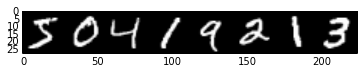

In [16]:
# we use a little trick to tile the first eight images
print solver.net.blobs['label'].data[:8]
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray')

# 上面的，解释一下，data 层原来结构是：('data', (64, 1, 28, 28))
# solver.net.blobs['data'].data[:8, 0]：选定前 8 张图的第一个 channel（其实也只有一个）
# 然后就维度就变成了 [n = 8, h, w]，输出一下
print "data[:8, 0].shape: ", solver.net.blobs['data'].data[:8, 0].shape

# 变换一下维度，原来是 [n, h, w] 现在是 [h, n, w]，也就是最大的 span 的那个维度是 h，一次可以把
# 8 张图片的行取到。
print "transpose(1, 0, 2): ", solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).shape
# 然后 reshape 一下，变成 [h, n*w],就把图片横着放了。
print "transpose(1, 0, 2): ", solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28).shape

关于维度，我想了一个比喻。对于数字 123，其实就是 ['1','2','3']，三个维度是 [百，十，个]，“百”的 span 是 100，“十”的 span 是 10，“个”的 span 是 1。跟这里的 [n,k,h,w] 可以类比。至于 transpose(1, 0, 2)，其实就是把
最大 span 的维度从“百”变成“十”，也就是具有同样十位数的数字放在一起（比如 120,28 原来就相隔很远，但
transpose 后距离就很近）。

[ 7.  2.  1.  0.  4.  1.  4.  9.]


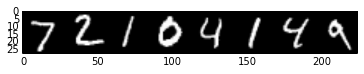

In [17]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray')
print solver.test_nets[0].blobs['label'].data[:8]

# 和上面一样，不过这次是测试网络。

Both train and test nets seem to be loading data, and to have correct labels.

Let's take one step of (minibatch) SGD and see what happens.

In [18]:
solver.step(1)

Do we have gradients propagating through our filters? Let's see the updates to the first layer, shown here as a $4 \times 5$ grid of $5 \times 5$ filters.

(20, 5, 5)
(4, 5, 5, 5)
(4, 5, 5, 5)
(20, 25)


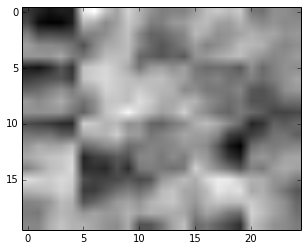

In [31]:
# params = [weights, diff]
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

# 最开始得维度是 [20, 1, 5, 5]，用了 [:, 0] 后变成 [20, 5, 5], 格式是 [n, h, w]
print solver.net.params['conv1'][0].diff[:, 0].shape
# 每 5 张图片放在一起, 共四组，一组五张图，所以维度变成了 [4, 5, 5, 5]，格式是：[n1, n2, h, w]
# 这里我把组数用 n1 (=4) 表示，每组图片数目用 n2 (=5) 表示。
print solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5).shape
# 然后 transpose(0, 2, 1, 3)，于是 [n1, n2, h, w] 变成了 [n1, h, n2, w]
print solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5).transpose(0, 2, 1, 3).shape
# 最后，用于显示，reshape(n1*h, n2*w) 这样就把 index 为 (i,j)  的图片（大小都是 w*h=5x5）放在了
# 正确的位置（i 是 0..n1-1, j 是 0..n2-1，（i,j）表示第 i 组，第 j 张图片。
# 因为组是更大的 span，所以一行是一组。
# 所以这里的索引其实是
#   (0,0)~ 0, (0, 1)~ 1, (0,2)~ 2, (0,3)~ 3, (0,4)~ 4
#   (1,0)~ 5, (1, 1)~ 6, (1,2)~ 7, (1,3)~ 8, (1,4)~ 9
#   (2,0)~10, (2, 1)~11, (2,2)~12, (2,3)~13, (2,4)~14
#   (3,0)~15, (3, 1)~16, (3,2)~17, (3,3)~18, (3,4)~19

print solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5).transpose(0, 2, 1, 3).reshape(4*5, 5*5).shape

那我们把上面这 4x5 个 filters 图片右下角的 2x3 显示出来。索引是 12, 13, 14, 17, 18, 19。

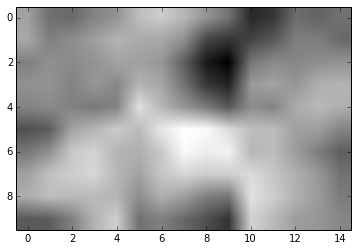

In [33]:
# 右下角的 2x3 个 filters。
imshow(solver.net.params['conv1'][0].diff[[12,13,14,17,18,19], 0].reshape(2, 3, 5, 5) # 两组 * 三张/每组
    .transpose(0, 2, 1, 3).reshape(2*5, 3*5), cmap='gray')

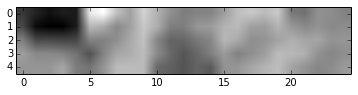

In [32]:
# 第一行
imshow(solver.net.params['conv1'][0].diff[:5, 0].reshape(1, 5, 5, 5)
    .transpose(0, 2, 1, 3).reshape(1*5, 5*5), cmap='gray')

Something is happening. Let's run the net for a while, keeping track of a few things as it goes.
Note that this process will be the same as if training through the `caffe` binary. In particular:
* logging will continue to happen as normal
* snapshots will be taken at the interval specified in the solver prototxt (here, every 5000 iterations)
* testing will happen at the interval specified (here, every 500 iterations)

Since we have control of the loop in Python, we're free to compute additional things as we go, as we show below. We can do many other things as well, for example:
* write a custom stopping criterion
* change the solving process by updating the net in the loop

In [ ]:
%%time
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

In [45]:
print solver.test_nets[0].blobs['ip2'].data.shape
print solver.test_nets[0].blobs['ip2'].data.argmax(1).shape
print solver.test_nets[0].blobs['ip2'].data.argmax(0)
solver.test_nets[0].blobs['ip2'].data.argmax(1)

(100, 10)
(100,)
[71 89 82 68 85 23 91 86 84 99]


array([7, 2, 1, 0, 4, 1, 4, 9, 2, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6,
       5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5,
       1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 2, 9, 3, 7, 4, 6, 4, 3,
       0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6,
       9, 3, 1, 4, 1, 7, 6, 9])

In [41]:
print type(solver.test_nets[0].blobs['ip2'].data) # numpy.ndarray
arr = np.array([])

arr.argmax?

<type 'numpy.ndarray'>
Object `numpy.argmax` not found.


**numpy.ndarray.argmax**

```
Docstring:
a.argmax(axis=None, out=None)

Return indices of the maximum values along the given axis.

Refer to `numpy.argmax` for full documentation.

See Also
--------
numpy.argmax : equivalent function
Type:      builtin_function_or_method
```

In [ ]:
solver.test_nets[0].blobs['ip2'].data

In [ ]:
solver.test_nets[0].blobs['ip2'].data.argmax

Let's plot the train loss and test accuracy. 把这两百组 iter 的 loss 和 accuracy 显示一下。

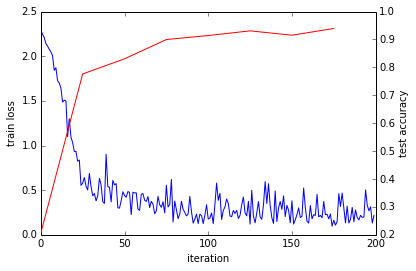

In [22]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')

The loss seems to have dropped quickly and coverged (except for stochasticity), while the accuracy rose correspondingly. Hooray!

Since we saved the results on the first test batch, we can watch how our prediction scores evolved. We'll plot time on the $x$ axis and each possible label on the $y$, with lightness indicating confidence.

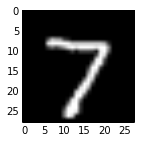

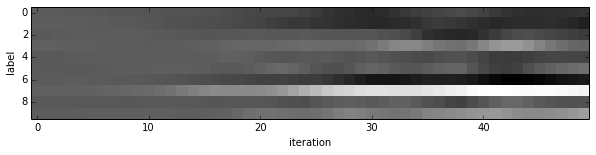

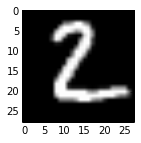

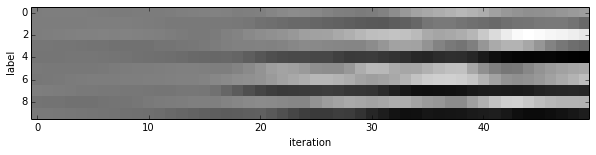

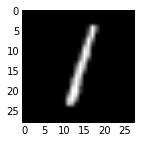

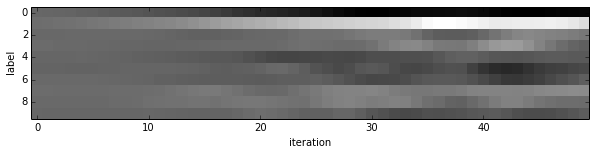

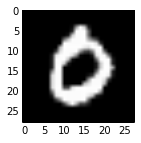

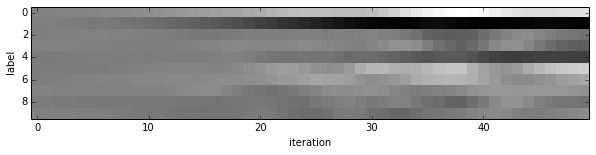

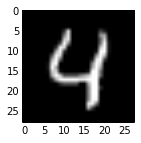

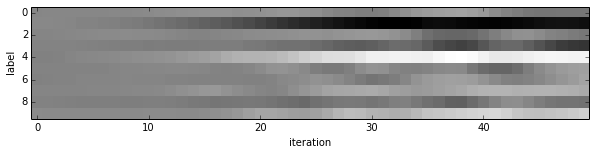

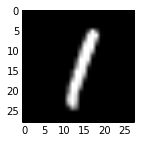

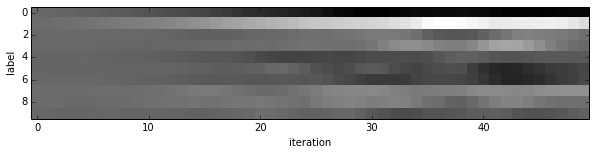

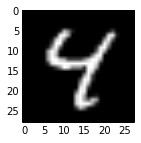

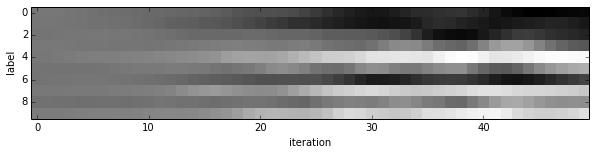

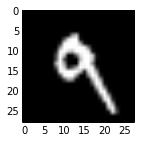

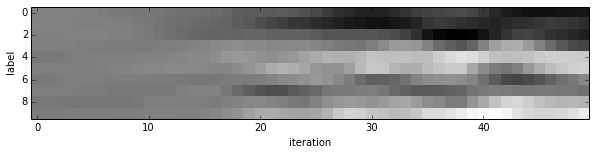

In [23]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

We started with little idea about any of these digits, and ended up with correct classifications for each. If you've been following along, you'll see the last digit is the most difficult, a slanted "9" that's (understandably) most confused with "4".

Note that these are the "raw" output scores rather than the softmax-computed probability vectors. The latter, shown below, make it easier to see the confidence of our net (but harder to see the scores for less likely digits).

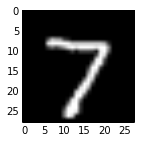

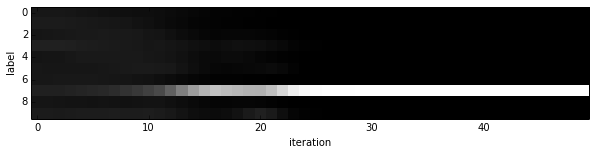

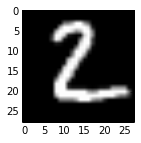

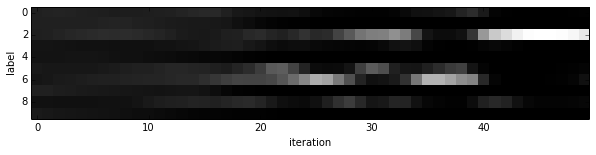

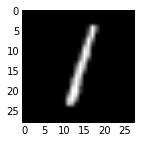

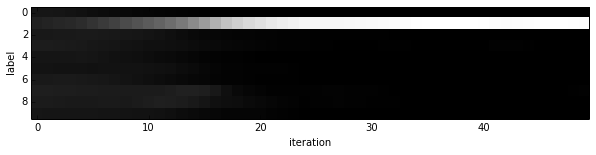

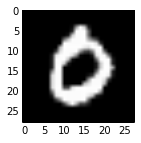

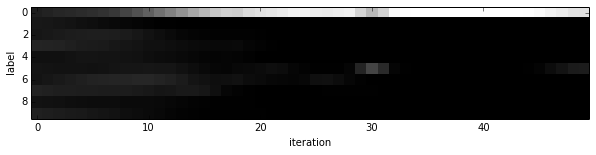

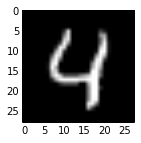

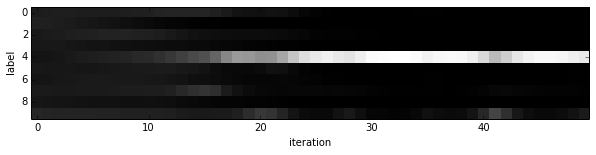

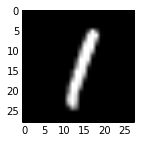

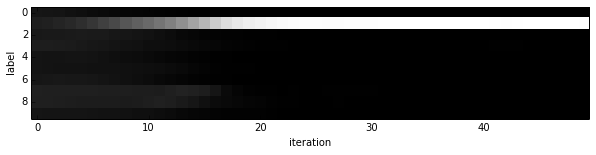

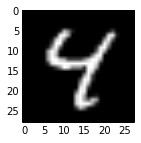

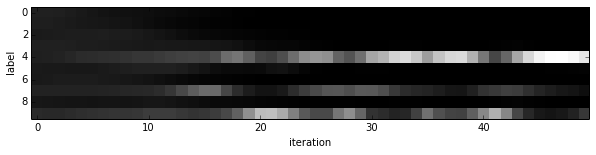

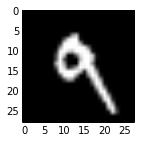

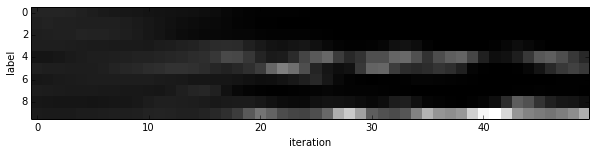

In [24]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(exp(output[:50, i].T) / exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')